# Determining the lightcurves of stellar clusters

This notebook is intended to be the same as the _cluster_lightcurves_ notebook except the clusters are analyzed in series, not in parallel, saving memory.

As a reminder, there are four methods I have tried using for determining what the range of fluxes should be for the sky mask. I've set the lower end to five units, but the upper end varies based on the cluster. Below are the four methods I have used to determine the highest flux a background pixel is allowed to have.

1. **The $n$th percentile of flux**. How do we choose $n$? Manually across the sectors? Also, if $n$ is constant across all the clusters, we are assuming that the "true" ratio of stars to sky is constant, which is probably not true.
1. **The most common flux**. The mode is not always a sharp peak in these histograms. How do we know it's physically meaningful as an upper limit to sky pixel flux?
1. **Fit the histograms to some distribution and use a statistical threshold**. This is probably the most physical of the options, but I have to pick a distribution and a statistic. Attempted distributions are listed below.
    - Poisson distribution: too steep and too easily turned into a normal distribution. Even if you right-shift it so that you can use lower shape parameters, it doesn't fit.
    - Normal distribution: Not the right shape. All the fits look bad.
1. **Devise an algorithm to count the number of stars in the picture and use that to determine $n$ in the first option.** I made the algorithm to count some feature proportional to the number of stars, but I don't know how to connect it to $n$.

I start by declaring default variables and loading modules

In [1]:
%matplotlib inline
import lightkurve as lk
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
import math

#CLUSTERS = ["NGC 752", "NGC 6231", "NGC 3532"]
CLUSTERS = ["M34", "M7", "NGC 752", "IC 2391", "NGC 6231", "Lambda Orionis", "NGC 3532", "Collinder 140", "Omega Cen", "47 Tuc", "NGC 6752"]
COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.78449002, 9.93415587), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113", "-31.85"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}
LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"
NUMBER_PCA_COMPONENTS = 5

Define a function to count maxima in an image's flux. Assume this number is proportional to the number of stars. This function is used for method 4.

In [2]:
def countMaxima(data):
    stars = 0
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            b = data[x][y]
            if np.isnan(b): continue
            up = data[x][y-1] if (y > 0 and not np.isnan(data[x][y-1])) else 0
            down = data[x][y+1] if (y < data.shape[1]-1 and not np.isnan(data[x][y+1])) else 0
            left = data[x-1][y] if (x > 0 and not np.isnan(data[x-1][y])) else 0
            right = data[x+1][y] if (x > data.shape[0]-1 and not np.isnan(data[x+1][y])) else 0
            if b > max(up, down, left, right):
                stars += 1
    return stars

In [3]:
def distribution(x, binwidth, shape):# Normal
    f = 180 * 180 * binwidth / math.sqrt(2 * 3.14159 * shape[1]**2) * math.exp(-(x - shape[0])**2 / (2 * shape[1]**2))
    
    return f

In [4]:
# Global values for method 1
PERCENTILE = 85

# Global values for method 2
BINS = 300


def getUpperLimit(method, image):
    if method == 1:
        return np.nanpercentile(image, PERCENTILE)
    
    elif method == 2:
        hist = np.histogram(image.reshape((180, 180)), bins=BINS, range=(0, 3000))# Bin the data
        return hist[1][np.argmax(hist[0])]# Return the flux corresponding to the most populated bin
    
    elif method == 3:
        pass
    
    elif method == 4:
        numMaxima = countMaxima(image)
        numPixels = np.count_nonzero(~np.isnan(image))
        return np.nanpercentile(image, 100 - numMaxima / numPixels * 100)
        
    else:
        return 150

In [5]:
tpfs = [0]*len(CLUSTERS)

class Cluster:
    def __init__(self, name):
        self.name = name
        self.tpf = 0
        
        foundLocal = False
        for file in os.listdir(LIGHTKURVE_CACHE):
            if file.endswith("180x180_astrocut.fits"): # Confirm size
                if COORDS[name][0] == float(file.split("_")[-4]): # Confirm RA
                    if COORDS[name][1] == float(file.split("_")[-3]): # Confirm dec
                        self.tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                        foundLocal = True
                        break
        if not foundLocal:
            search = lk.search_tesscut(name)
            char = ""
            if len(search) != 1: char = "s"
            print("{0} has {1} result{2}.".format(self.name, len(search), char))
            self.tpf = search[0].download(cutout_size=180)
            
        self.frame = self.tpf.shape[0] // 2
        self.image = self.tpf[self.frame].flux.reshape((180, 180))
            
    def displayTPF(self):
        p = self.tpf.plot(frame=self.frame)
        p.set_title(self.name)
        
    def displayHist(self):
        brightnessData = self.image.reshape(180*180)
        mean = np.mean(brightnessData)
        lower_limit = 0
        upper_limit = int(2 * mean)
        brightnessData = brightnessData[np.where((brightnessData >= lower_limit) & (brightnessData <= upper_limit))]

        # Count stars
        numMaxima = countMaxima(self.image)
        numPixels = np.count_nonzero(~np.isnan(self.image))
        print("{0}: {1} / {2} = {3}%.".format(self.name, numMaxima, numPixels, numMaxima / numPixels*100))

        # Draw field
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
        self.tpf.plot(ax=ax1, frame=self.frame)
        ax1.set_title(self.name)

        # Make distribution
        x = np.arange(start=0, stop=upper_limit, step=int(upper_limit/100))
        shape = norm.fit(brightnessData)
        y = np.array([distribution(k, (upper_limit - lower_limit) / 100, shape) for k in x])

        # draw histogram and distribution
        ax2.hist(brightnessData, bins=100)
        ax2.axvline(mean, color='k')
        ax2.plot(x, y, color='r', zorder=2)
        
    def getMasks(self, method):
        self.method = method
        lowerLimit = 5
        upperLimit = getUpperLimit(method, self.image)
        print("{0}: [{1}, {2}]".format(self.name, lowerLimit, upperLimit))
        
        self.skyMask = ((self.image >= lowerLimit) & # Exclude edge pixels
            (self.image <= upperLimit)).reshape(180, 180)
        self.starMask = ((self.image > upperLimit)).reshape(180, 180)
        
    def displayMasks(self):
        skyFlux = np.ma.array(self.image, mask=~self.skyMask).reshape(180, 180).filled(fill_value=0)
        starFlux = np.ma.array(self.image, mask=~self.starMask).reshape(180, 180).filled(fill_value=0)
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))
        ax1.imshow(skyFlux, vmin=0, vmax=np.nanpercentile(self.image, 95))
        ax1.set_title(self.name + " sky mask values")
        ax2.imshow(starFlux, vmin=0, vmax=np.nanpercentile(self.image, 95))
        ax2.set_title(self.name + " star mask values")
        
    def generateLightcurve(self):
        self.lc = self.tpf.to_lightcurve(aperture_mask=self.starMask)

        regressor = self.tpf.flux[:, self.skyMask]# The regressor is the inverse of the aperture

        dm = lk.DesignMatrix(regressor, name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant()
        corrector = lk.RegressionCorrector(self.lc)
        self.correctedLC = corrector.correct(dm)
        
    def displayLightcurves(self):
        plot = self.lc.plot(marker='.', ls='none', color='r');# This is where you would flatten the curves
        plot2 = self.correctedLC.plot(marker='.', ls='none', color='b');# This is where you would flatten the curves
        plot.set_title("TESS 2-min lightcurve for {0}: method {1}.".format(self.name, self.method));
        plot2.set_title("TESS 2-min lightcurve for {0}: method {1}, corrected.".format(self.name, self.method));

M34: [5, 246.9876057624817]


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater


M7: [5, 1699.1773513094004]


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater


NGC 752: [5, 283.31466217041014]
IC 2391: [5, 457.7813312163177]
NGC 6231: [5, 963.8143711740004]


Error initializing plugin EntryPoint(name='Windows (alt)', value='keyrings.alt.Windows', group='keyring.backends').
Traceback (most recent call last):
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/importlib_metadata/__init__.py", line 96, in load
    module = import_module(match.group('module'))
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_f

Lambda Orionis has 1 result.
Lambda Orionis: [5, 348.05824570832436]
NGC 3532: [5, 2485.425495288989]


/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


Collinder 140 has 1 result.
Collinder 140: [5, 451.04682690622286]


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

Omega Cen: [5, 1138.980992296007]


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memor

47 Tuc: [5, 340.99438806039325]


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memor

NGC 6752 has 1 result.
NGC 6752: [5, 173.16567906205373]


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/lightcurve.py:1249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

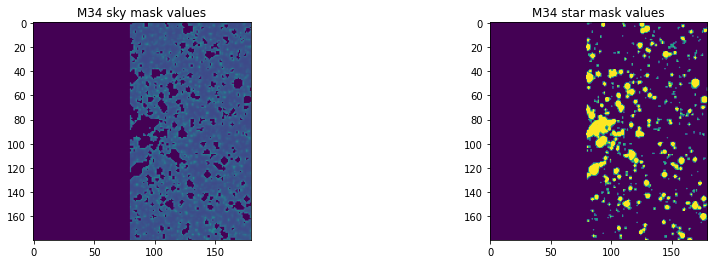

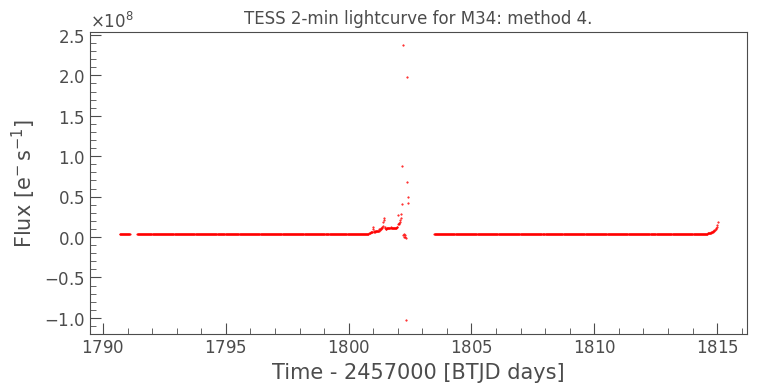

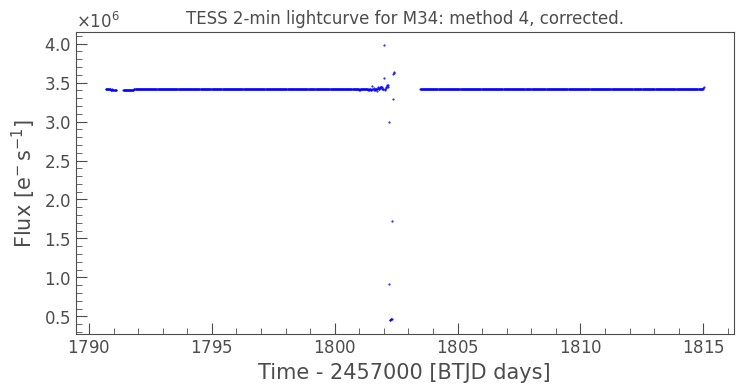

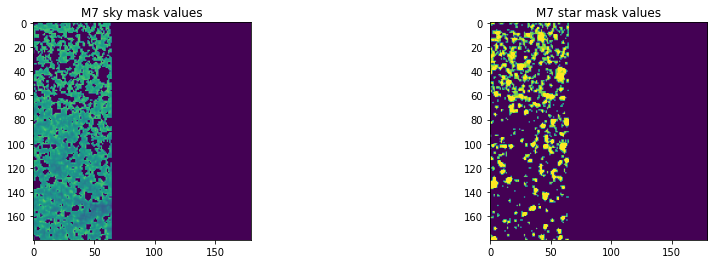

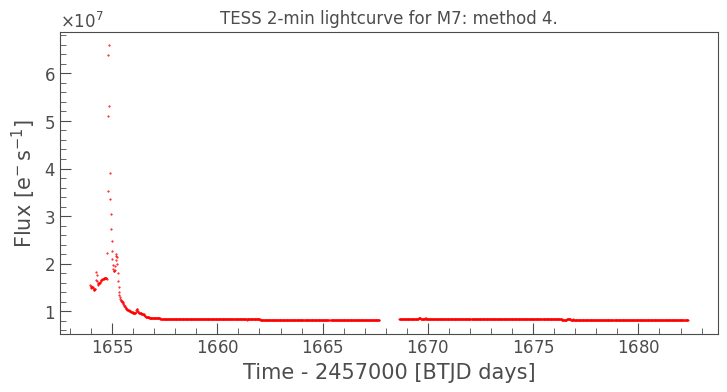

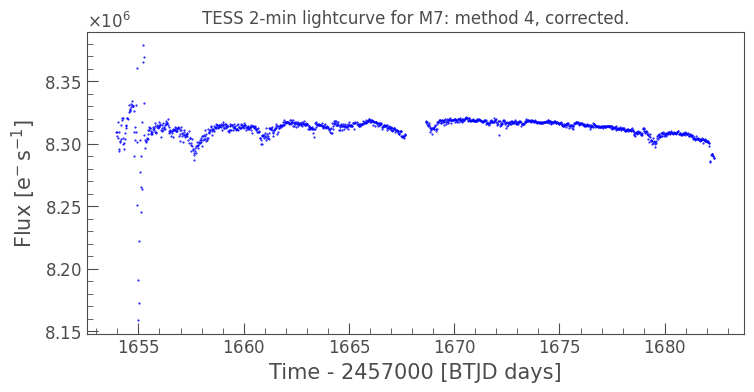

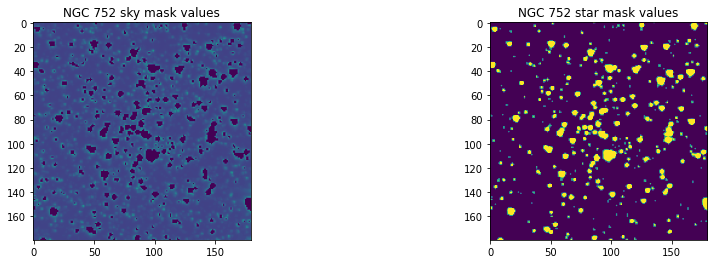

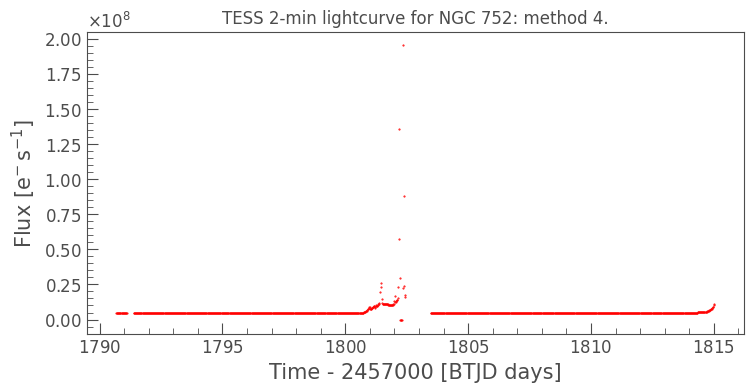

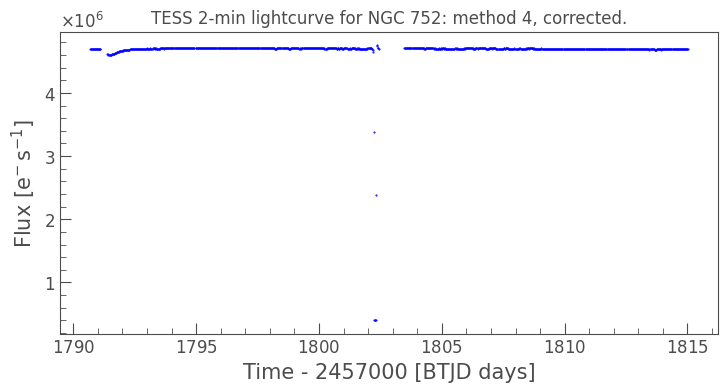

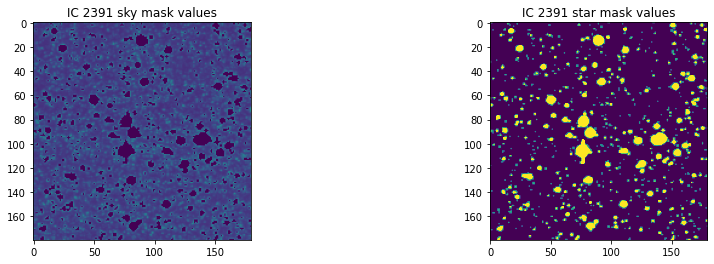

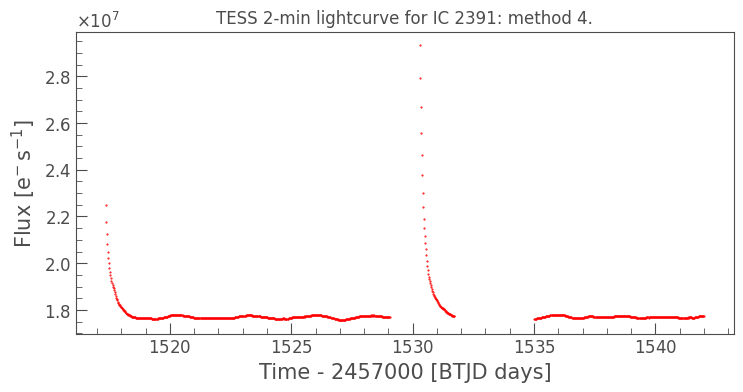

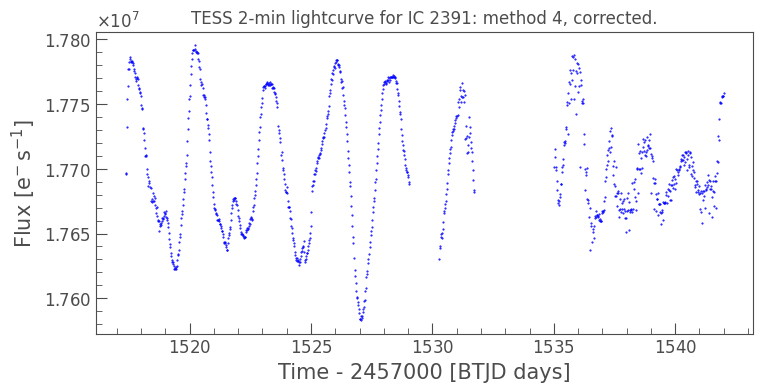

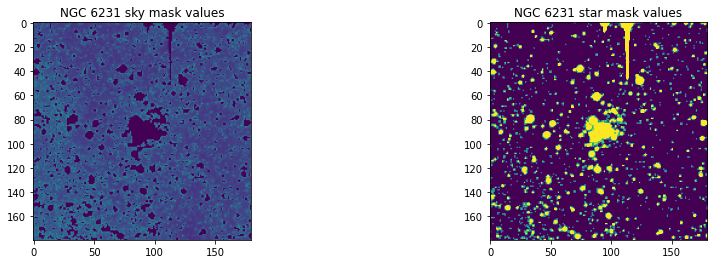

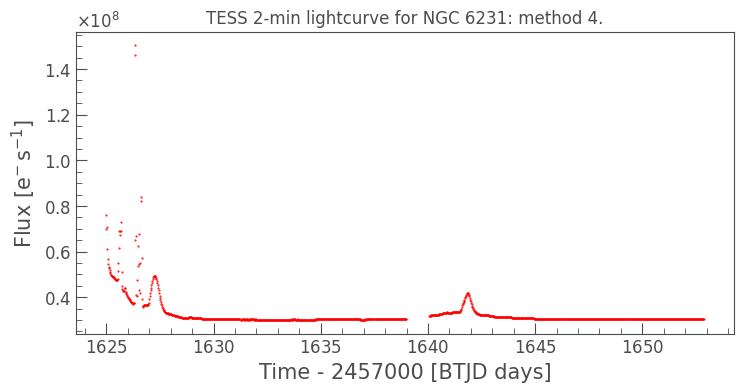

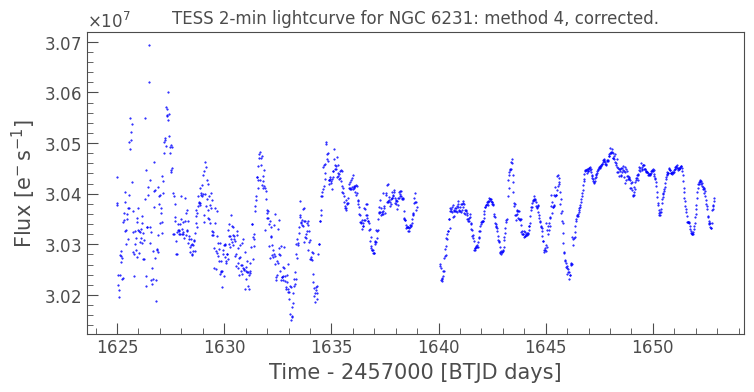

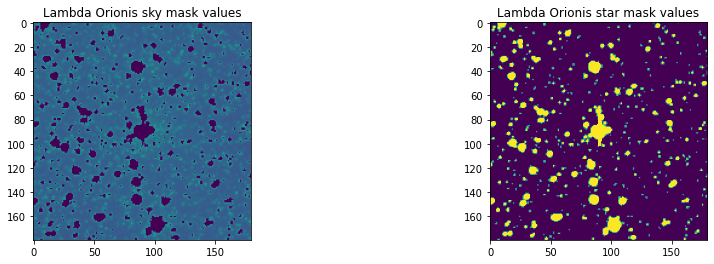

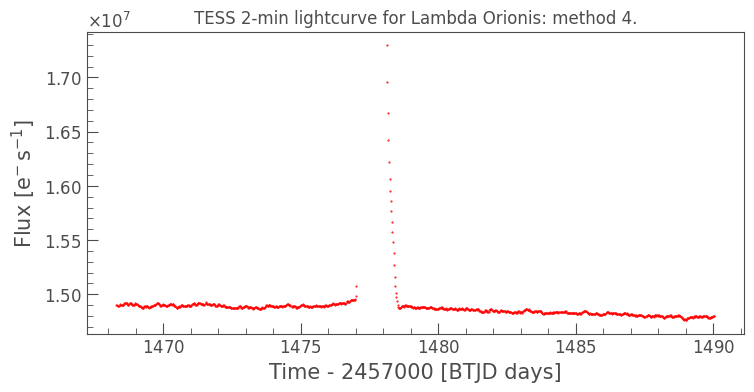

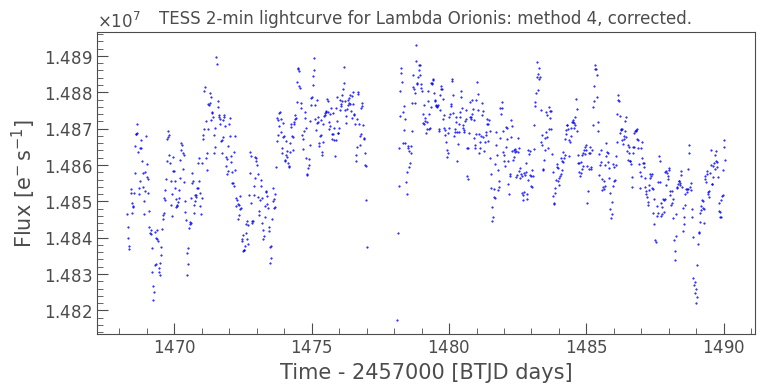

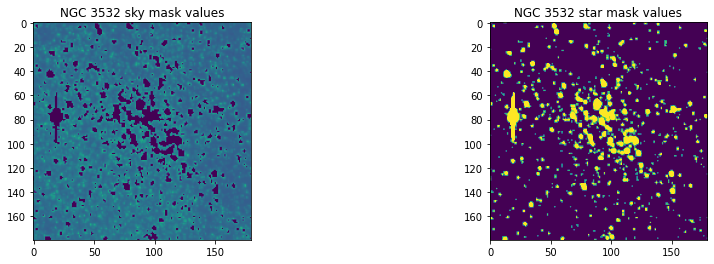

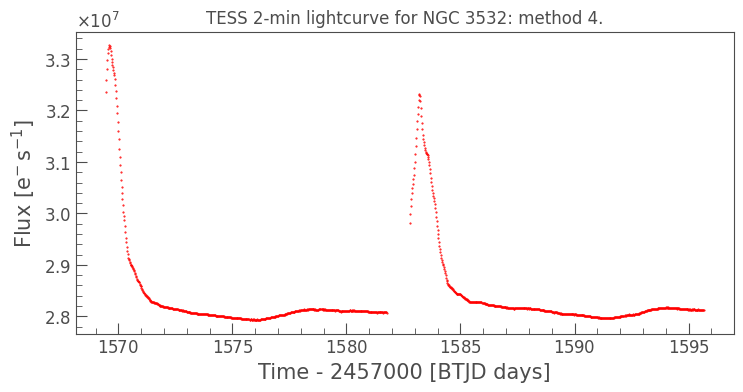

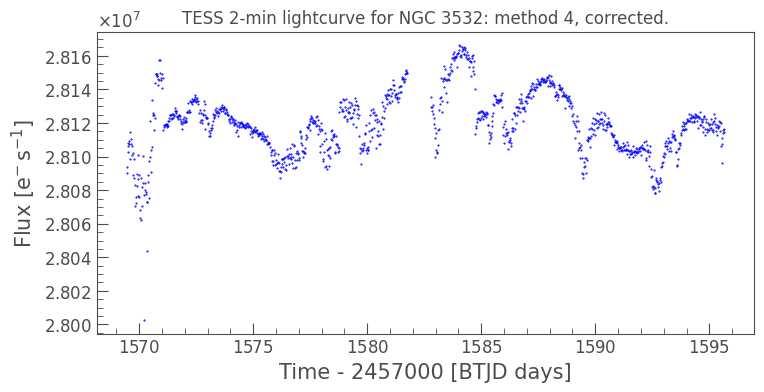

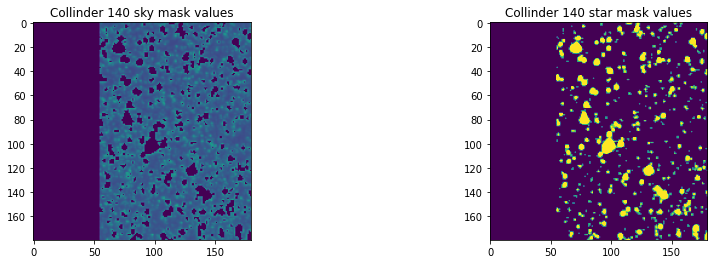

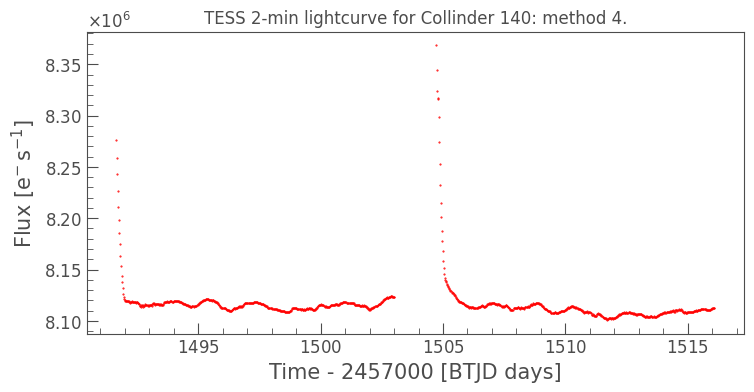

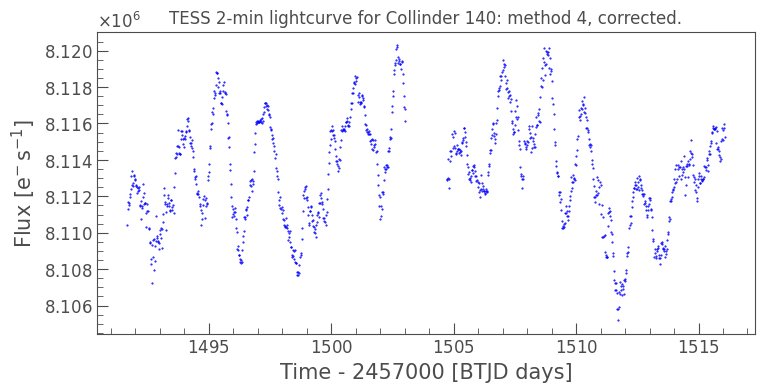

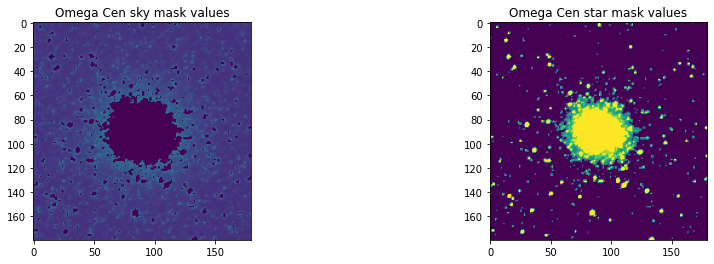

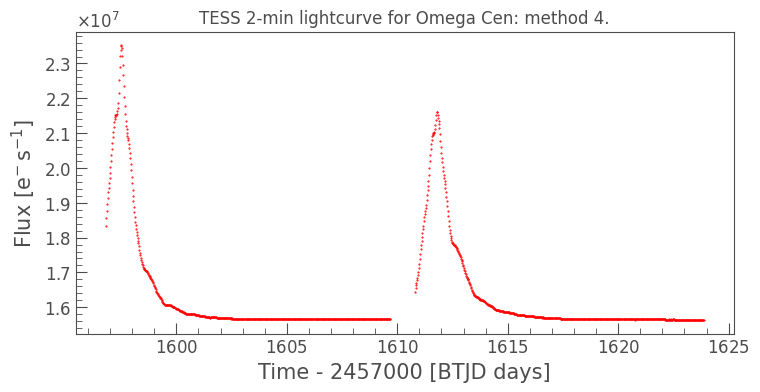

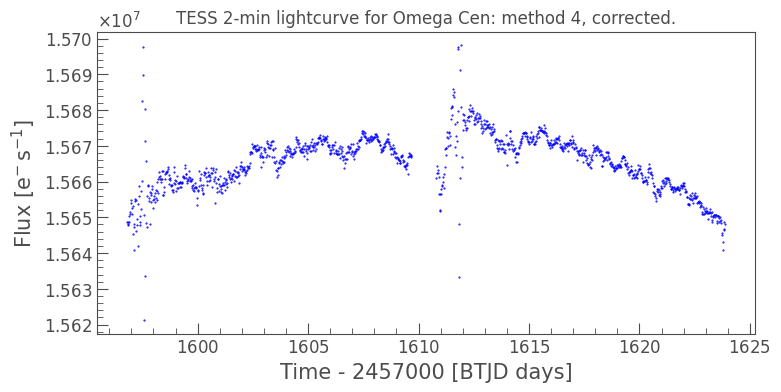

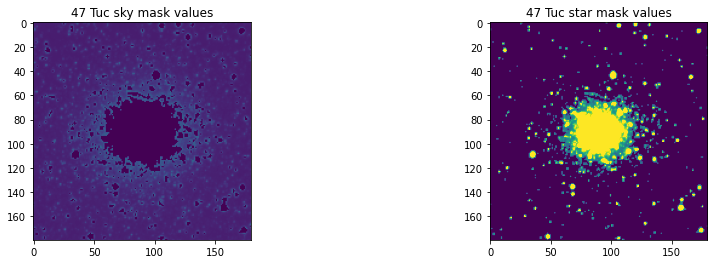

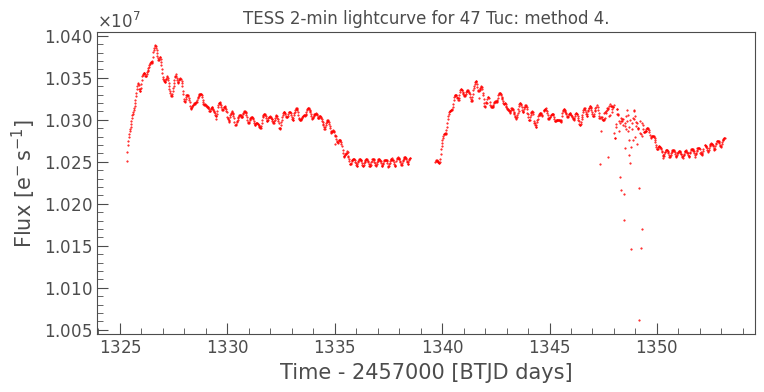

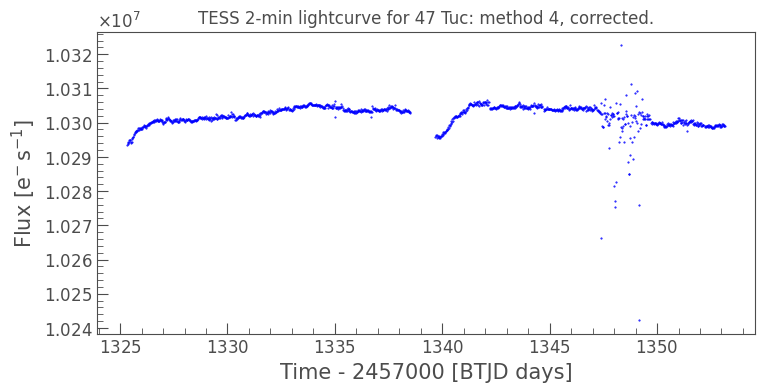

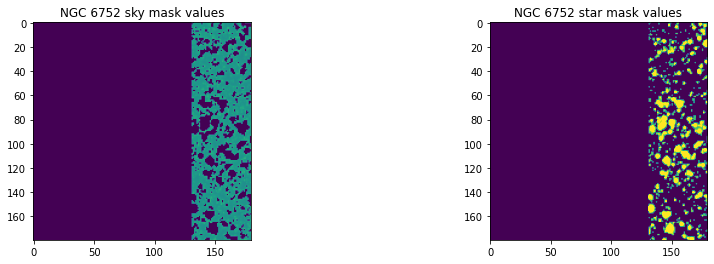

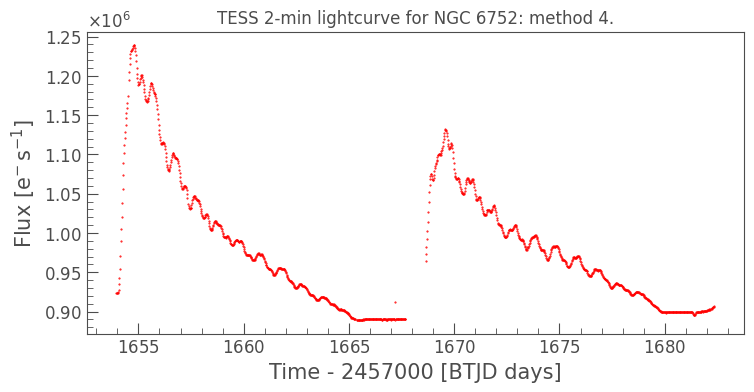

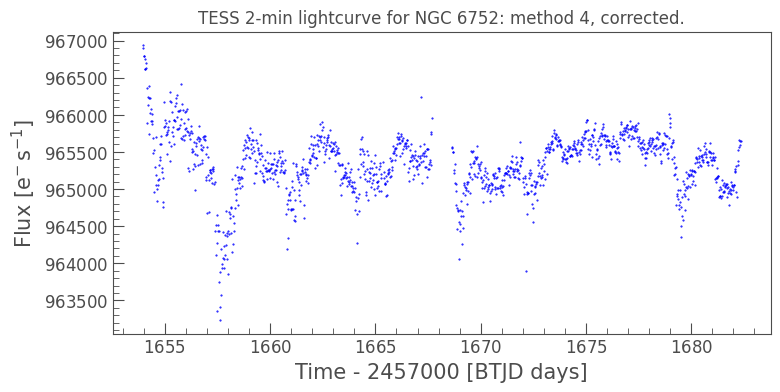

In [6]:
UPPER_LIMIT_METHOD = 4

for c in CLUSTERS:
    cl = Cluster(c)
    #cl.displayTPF()
    #cl.displayHist()
    cl.getMasks(UPPER_LIMIT_METHOD)
    cl.displayMasks()
    cl.generateLightcurve()
    cl.displayLightcurves()

Now you can run this for as many clusters as you like and the kernel should not die. Tested on 8 GB of memory.